# Классификация текстов с использованием BERT

In [157]:
import pandas as pd
import numpy as np 
np.random.seed(seed=42)
import time
from tqdm import notebook

import torch
import transformers 

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


from IPython.display import display
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

Импортируем и изучим данные. Нам предстоит решить задачу бинарной классификации. Необходимо выделить признаки из текста и определить, является ли он токсичным (негативным) комментарием или нет. 

In [2]:
try:
    df = pd.read_csv('/Users/anshilina/Downloads/toxic_comments.csv').drop('Unnamed: 0', axis=1)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv').drop('Unnamed: 0', axis=1)
    
display(df.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
display(df.describe())

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [154]:
print('Количество пропусков:', df.isna().sum().sum())

Количество пропусков: 0


In [155]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


Визуализируем распределение зависимой переменной. Мы можем наблюдать дисбаланс в классах – в выборке больше комментариев, которые не являются токсичными. При моделировании необходимо учесть дисбаланс. Для этого мы будем использовать специальные параметры моделей. 

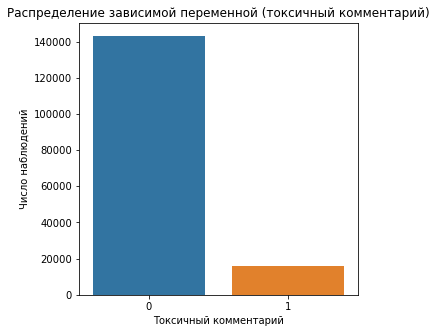

In [156]:
plt.figure(figsize=(5,5))
sns.barplot(data=df, x=df['toxic'].value_counts().index, y=df['toxic'].value_counts().values)
plt.xlabel('Токсичный комментарий')
plt.ylabel('Число наблюдений')
plt.title('Распределение зависимой переменной (токсичный комментарий)')
plt.show()

## Подготовка

Получим эмбединги токенов из каждого текста.

In [3]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

In [4]:
tokenized = []
for i in notebook.tqdm(range(df['text'].shape[0])):
    tokenized.append(tokenizer.encode(df['text'][i], max_length=512, truncation=True, add_special_tokens=True))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [5]:
print('Первые пять токенов первого текста:', tokenized[0][:5])

Первые пять токенов первого текста: [101, 7526, 2339, 1996, 10086]


In [6]:
max_vector = max(len(token) for token in tokenized)
print('Размер самого длинного токена:', max_vector)

Размер самого длинного токена: 512


In [31]:
padded = np.array([i + [0]*(max_vector - len(i)) for i in tokenized])

Теперь поясним модели, что нули не несут значимой информации.

In [32]:
attention_mask = np.where(padded != 0, 1, 0)

Инициализируем конфигурацию BertConfig (англ. Bert Configuration) и модель класса BertModel. Передадим ей файл с предобученной моделью и конфигурацией.

In [9]:
config = transformers.BertConfig.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained('unitary/toxic-bert', config=config)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [72]:
idx = np.random.randint(padded.shape[0], size=4000)
padded = padded[idx, :]
df_new = df.iloc[idx].copy()

In [73]:
batch_size = 5
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) 
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy()) 

  0%|          | 0/800 [00:00<?, ?it/s]

In [132]:
features = np.concatenate(embeddings) 
train_features, test_features, train_target, test_target = train_test_split(
    features, df_new['toxic'], test_size=0.1, shuffle=True)

## Обучение

Обучим модели логистической регрессии, случайного леса, CatBoost, LightGBM, XGBoost. Модель дерева решений рассмотрим в качестве базовой – будем сравнивать с ней значения других классификаторов.

Инициализируем стратифицированное разделение на фолды, которые мы будем использовать при обучении подели и подборе параметров. Другими словами, на кросс-валидации наши данные будут делиться в тренировочную и валидационную выборку, учитывая исходное соотношение классов.

In [164]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Дерево решений

In [165]:
tree_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
tree_params = {
    'max_depth' : range(2, 13, 2),
    'min_samples_leaf' : range(1, 5),
    'min_samples_split': range(2, 10, 2),
}
tree_model = GridSearchCV(tree_model, param_grid=tree_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [166]:
tree_start = time.time()
tree_model.fit(train_features, train_target)
tree_grid_time = time.time() - tree_start

In [167]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(tree_grid_time/60, 2)} мин')
print(f'Время обучения модели: {round(tree_model.cv_results_["mean_fit_time"][tree_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(tree_model.cv_results_["mean_score_time"][tree_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров:{tree_model.best_params_}')
print(f'F1 на кросс-валидации:', tree_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 2.48 мин
Время обучения модели: 3.16062 сек
Время предсказания модели: 0.01492 сек
Лучшие значения параметров:{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 8}
F1 на кросс-валидации: 0.3445050044879181


### Логистическая регрессия

In [168]:
log_model = LogisticRegression(solver='liblinear', class_weight='balanced')
log_params = {
    'C':range(5,25,5),
}
log_model = GridSearchCV(log_model, param_grid=log_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [169]:
log_start = time.time()
log_model.fit(train_features, train_target)
log_grid_time = time.time() - log_start

In [170]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(log_grid_time, 2)} сек')
print(f'Время обучения модели: {round(log_model.cv_results_["mean_fit_time"][log_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(log_model.cv_results_["mean_score_time"][log_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров: {log_model.best_params_}')
print(f'F1 на кросс-валидации:', log_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 22.79 сек
Время обучения модели: 4.73916 сек
Время предсказания модели: 0.01512 сек
Лучшие значения параметров: {'C': 20}
F1 на кросс-валидации: 0.6640923970601357


### Случайный лес

In [176]:
forest_model = RandomForestClassifier(random_state=42, class_weight='balanced')
forest_params = {
    'max_depth' : range(5, 12, 2),
    'n_estimators': range(10, 50, 10),
}
forest_model = GridSearchCV(forest_model, param_grid=forest_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [177]:
forest_start = time.time()
forest_model.fit(train_features, train_target)
forest_grid_time = time.time() - forest_start

In [178]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(forest_grid_time, 2)} сек')
print(f'Время обучения модели: {round(forest_model.cv_results_["mean_fit_time"][forest_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(forest_model.cv_results_["mean_score_time"][forest_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров:{forest_model.best_params_}')
print(f'F1 на кросс-валидации:', forest_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 21.13 сек
Время обучения модели: 2.86887 сек
Время предсказания модели: 0.02817 сек
Лучшие значения параметров:{'max_depth': 9, 'n_estimators': 40}
F1 на кросс-валидации: 0.49923771326712496


In [179]:
classes = np.unique(train_target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target)
class_weights = dict(zip(classes, weights))

### Cat Boost Classifier

In [180]:
cat_model = CatBoostClassifier(class_weights=class_weights, random_seed=42, loss_function='Logloss', silent=True)

In [181]:
cat_start = time.time()
cat_model.fit(train_features, train_target)
cat_fit_time = time.time() - cat_start

In [182]:
cat_start = time.time()
cat_model.predict(train_features)
cat_pred_time = time.time() - cat_start

In [183]:
print('Результаты обучения.\n')
print(f'Время обучения модели: {round(cat_fit_time/60, 5)} мин')
print(f'Время предсказания модели: {round(cat_pred_time, 5)} сек')
print('F1 на кросс-валидации:', np.mean(cross_val_score(
    cat_model, train_features, train_target, cv=k_fold, scoring='f1', n_jobs=-1)))

Результаты обучения.

Время обучения модели: 1.01213 мин
Время предсказания модели: 0.03864 сек
F1 на кросс-валидации: 0.7150512208303099


### LGBM Classifier

In [184]:
lgbm_model = LGBMClassifier(class_weight=class_weights, random_state=42, n_jobs=-1)
lgbm_params = {
    'n_estimators': range(80, 100, 5),
}
lgbm_model = GridSearchCV(lgbm_model, param_grid=lgbm_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [185]:
lgbm_start = time.time()
lgbm_model.fit(train_features, train_target)
lgbm_search_time = time.time() - lgbm_start

In [186]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(lgbm_search_time, 2)} сек')
print(f'Время обучения модели: {round(lgbm_model.cv_results_["mean_fit_time"][lgbm_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(lgbm_model.cv_results_["mean_score_time"][lgbm_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров: {lgbm_model.best_params_}')
print(f'F1 на кросс-валидации:', lgbm_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 55.75 сек
Время обучения модели: 17.5875 сек
Время предсказания модели: 0.04718 сек
Лучшие значения параметров: {'n_estimators': 90}
F1 на кросс-валидации: 0.676963576063621


### XGBoost Classifier

In [187]:
xgb_class_weight = float(np.sum(train_target == 0) / np.sum(train_target == 1))

In [188]:
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=xgb_class_weight)
xgb_params = {
    'max_depth': range(6,10,2),
    'n_estimators': range(50,90,10),
}
xgb_model = GridSearchCV(xgb_model, param_grid=xgb_params, cv=k_fold, scoring='f1', n_jobs=-1)

In [189]:
xgb_start = time.time()
xgb_model.fit(train_features, train_target)
xgb_search_time = time.time() - xgb_start

In [190]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(xgb_search_time/60, 2)} мин')
print(f'Время обучения модели: {round(xgb_model.cv_results_["mean_fit_time"][xgb_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(xgb_model.cv_results_["mean_score_time"][xgb_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров: {xgb_model.best_params_}')
print(f'F1 на кросс-валидации:', xgb_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 4.33 мин
Время обучения модели: 45.42939 сек
Время предсказания модели: 0.10893 сек
Лучшие значения параметров: {'max_depth': 6, 'n_estimators': 60}
F1 на кросс-валидации: 0.6597644382104878


**Вывод:** Лучший показатель на кросс-валидации у CatBoost классификатора, хотя обучается он медленнее остальных моделей. Результаты сравнения представлены в таблице.

|Модель|Время обучения|Время предсказания| F1 score на валидации|
|:---|:---|:---|:---|
|CatBoost|1 мин|0.04 сек|0.72|
|LightGBM|17.6 сек|0.05 сек|0.68|
|Логистическая регрессия|4.7 сек|0.01 сек|0.66|
|XGBoost|45.4 сек|0.11 сек|0.66|
|Случайный лес|2.9 сек|0.03 сек|0.50|
|Дерево решений|3.2 сек|0.01 сек|0.34|

## Выводы

In [192]:
print('Результаты предсказания логистической регрессии на тестовой выборке.\n')
print('F1 на тестовой выборке:', f1_score(test_target, cat_model.predict(test_features)))

Результаты предсказания логистической регрессии на тестовой выборке.

F1 на тестовой выборке: 0.8125000000000001


In [193]:
proba_test = log_model.predict_proba(test_features)[:,1]
print('AUC-ROC:', roc_auc_score(test_target, proba_test))

AUC-ROC: 0.9183455433455433


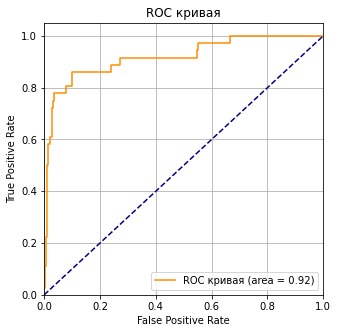

In [194]:
fpr, tpr, treshold = roc_curve(test_target, proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Выводы

В проекте была решена задача классификации комментариев на токсичные и не токсичные. Целевая метрика была достигнута – качество на тестовой выборке (F1 score) – 0.81.

На первом этапе исследования мы получили признаки из текста. Мы токенизировали слова и получили их эмбеддинги, используя модель BERT (конфигурация toxic bert). В процессе подготовки данных мы также обнаружили дисбаланс в классах – комментариев, которые не являются токсичными, намного больше чем тех, что являются токсичными. Эту проблему мы постарались учесть, задав соответсвующие параметры моделей.

Далее мы обучили шесть моделей – Дерево решений, Случайный лес, Логистическую регрессию, а также модели градиентного бустинга CatBoost, LightGBM и XGBoost. Получив результаты обучения, мы сравнили метрики качества, а также скорость обучения и предсказания моделей. В результате в качестве итоговой модели, которую предлагается использовать для поиска токсичных комментариев, был выбран **CatBoost** классификатор.